# <h1><center>*Predicting Bitcoin's Price*</center></h1>

# Goals:

- Identify if there is a correlation between BTC (Bitcoin), DJI (Dow Jones Industrial Average), and Gold 
- Build a model to best predict BTC's price in the next 6 months
 ___

# Imports

In [1]:
import pandas as pd
import numpy as np 

import yfinance as yf
import mplfinance as mpf

import acquire as a
import prepare as p
import explore as e
import modeling as m

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

from sklearn.metrics import mean_squared_error
from math import sqrt 

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

---------------------------------------------------------------------------------------------------------------

# Acquire

 - Data acquired through Yahoo Finance Library
 - Wrote a function in my acquire.py file that includes to extract the data
 - Combined the 3 different dataframes
 - It contained 2,085 rows and 3 columns before cleaning
 - Each row represents a specific day in the dataset
 - Each column represents the price related to each asset 
 
 __________

# Prepare

 - Checked for nulls in the data(there were none)
 - Checked that column data types were appropriate
 - Renamed columns
 - Resampled data into Yearly, Quarterly, Monthly and assigned to their respective variables
 - Split data into train, validate and test (approx. 50/30/20)
 
 _____

# Data Dictionary


| Target Variable |     Definition     |
| --------------- | ------------------ |
|      btc_price    | price of Bitcoin |

| Feature  | Definition |
| ------------- | ------------- |
| open | Opening price of the asset |
| high | The high price point of the asset  |
| low | The low price point of the asset |
| close | The closing price of the asset |
| adj close | The closing price after adjustments |
| volume | The amount of an asset that changes hands | 
| dji_price | The price of the Dow Jones Industrial Average |
| gold | The price of gold per ounce|

_____

# A brief look at the data

In [2]:
# acquiring and merging the necessary data 
btc_df, gold_df, dji_df = a.asset_price(2010)
df = a.merged_assets(btc_df, gold_df, dji_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# preparing and cleaning the data
df, df_year, df_month, df_quarter = p.clean_df(df)

In [4]:
# splitting data into train, validate, and test
train, validate, test = p.split_data_explore(df)
train.shape, validate.shape, test.shape

((1042, 3), (626, 3), (417, 3))

In [5]:
#displaying all columns and getting first 5 rows
train.head()

,btc_price,gold_price,dji_price
date,,,
2014-09-17,457.33,1234.4,17156.85
2014-09-18,424.44,1225.7,17265.99
2014-09-19,394.80,1215.3,17279.74
2014-09-22,402.15,1216.8,17172.68
2014-09-23,435.79,1221.0,17055.87


# A summary of the data

In [6]:
# a look at our column names, data types, and null counts
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042 entries, 2014-09-17 to 2018-11-07
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   btc_price   1042 non-null   float64
 1   gold_price  1042 non-null   float64
 2   dji_price   1042 non-null   float64
dtypes: float64(3)
memory usage: 32.6 KB


# Explore

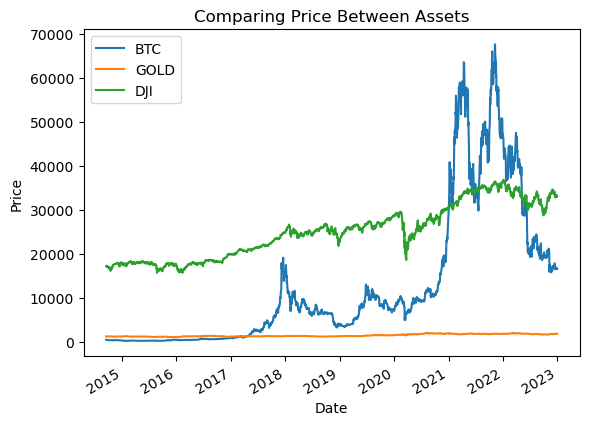

In [7]:
# a line graph comparing the 3 assets
e.plot(df)

### **1. Does BTC's price have a correlation with the DJI?**

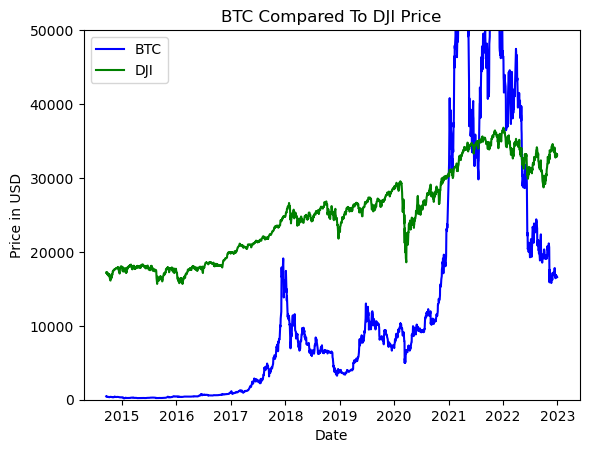

In [8]:
# a line graph comparing BTC and DJI prices
e.comparing_assets(df, 'btc_price', 'dji_price')

$H_0$: There is no correlation between the BTC and DJI price

$H_a$: There is a correlation between the BTC and DJI price

Confidence Interval 95%<br>
$\alpha$ = 0.05

In [9]:
# stats testing correlation between 2 assets
e.pearsons_test(df, 'btc_price', 'dji_price')

Pearson's correlation coefficient: 0.8560544423948482
p-value: 0.0
We reject the null hypothesis


**Takeaways**

- We reject the null hypothesis meaning there is a correlation between the DJI and BTC price. There is a strong correlation to be specific. Meaning that BTC seems to follow the trend of the DJI
____

### **2. Does BTC's price have a relationship with Gold?** 

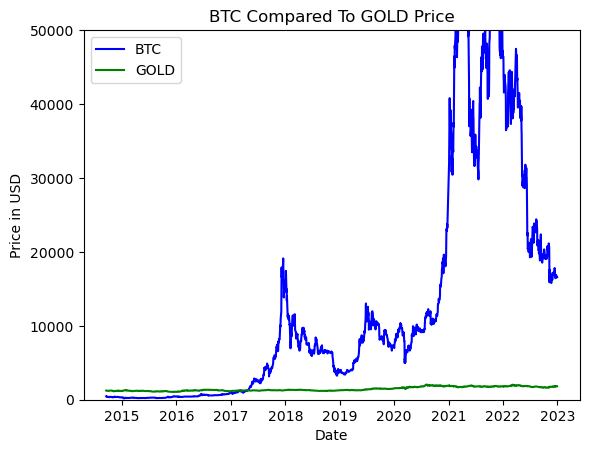

In [10]:
# a line plot showing us BTC and Gold prices
e.comparing_assets(df, 'btc_price', 'gold_price')

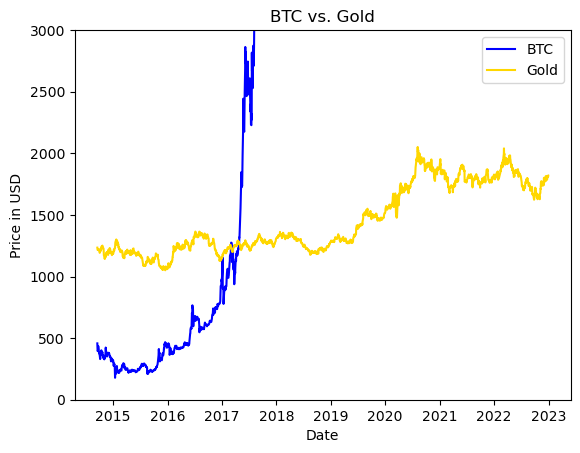

In [11]:
e.zoomed_in(df)

$H_0$: There is no correlation between the BTC and Gold price

$H_a$: There is a correlation between the BTC and Gold price

Confidence Interval 95%<br>
$\alpha$ = 0.05

In [12]:
# stats testing if there is a correlatin between BTC and Gold
e.pearsons_test(df, 'btc_price', 'gold_price')

Pearson's correlation coefficient: 0.7642495379265786
p-value: 0.0
We reject the null hypothesis


**Takeaways**

- We reject the null hypothesis meaning there is a correlation between BTC and Gold having a positive correlation. With a 76% poistive correlation making it mildly strong. 


--------

### **3. How does the volatility of BTC compare with that of the DJI and Gold?**

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BTC Volatility: 0.03816496621162785
DJI Volatility: 0.010854783277123137
Gold Volatility: 0.010191738788816374


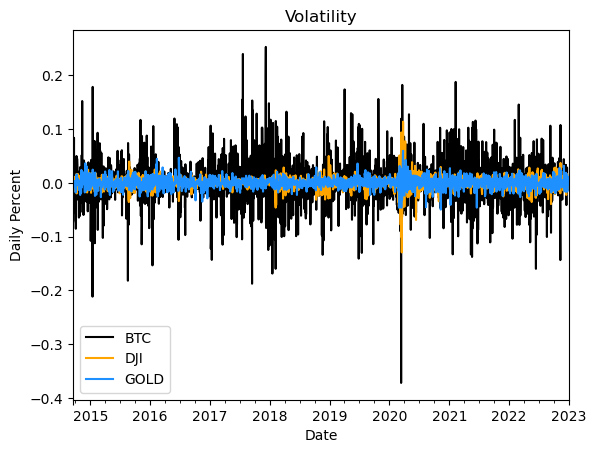

In [13]:
# a line graph showing the volatility of the assets
e.volatility(2010)

**Takeaways**

- We see from the chart that BTC is very volatile compared to the DJI and Gold on a daily basis. 
_____

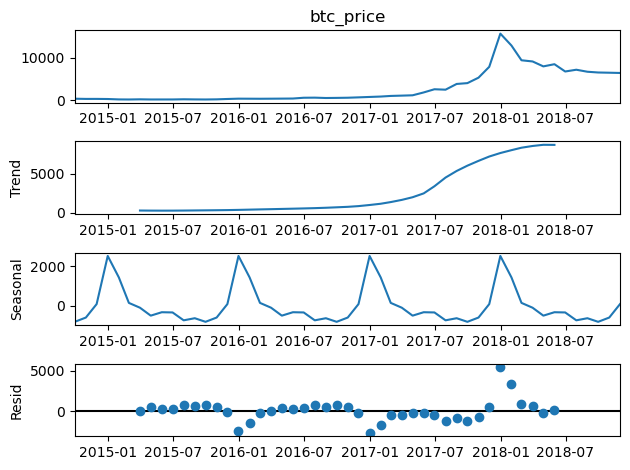

In [14]:
# a decomposition chart of BTC prices
e.seasonal_charts(train)

# Exploration Summary

**- We found that both Gold and the DJI have a mild to high correlation with BTC respectively**<br>
**- Even though there a correlation with the other two assets BTC is much more volatile**<br>
**- BTC's price seems to have a seasonal pattern, with an upward trend**

# Modeling 

- Goal is to minimize RMSE, so this will be my evaluation metric
- Ran 3 models including a Linear Regression , LassoLars, and a Polynomial 
- Before modeling scaled data and split
- I evaluated the models on train and validate data 
- The best performing model then was evaluated on test data subset

### Resplit BTC data

In [15]:
# wrote a function to split BTC data into my train, validate, and test data subsets
train, validate, test = m.resplit_btc(btc_df)
train.shape[0], validate.shape[0], test.shape[0]

(1843, 614, 614)

In [16]:
# looking at one line of data in our train data
train.head(1)

,btc_price
date,
2014-09-17,457.334015


btc_price -- RMSE: 20028


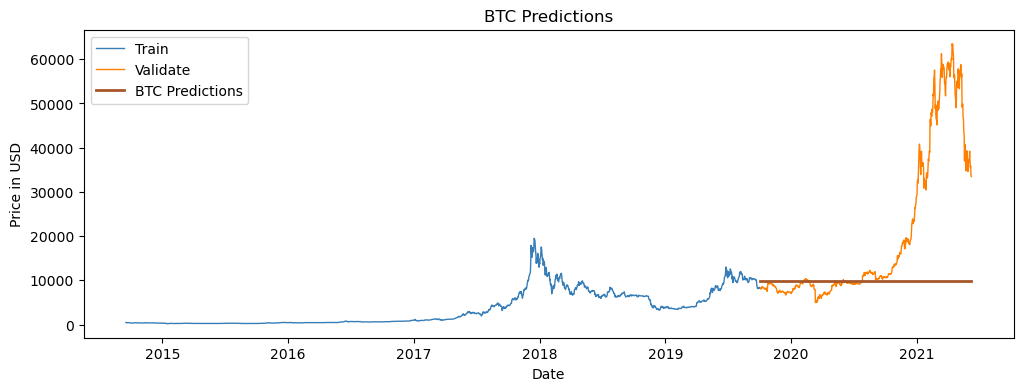

In [17]:
# a look to our baseline model
yhat_df = m.baseline_model(train, validate)
m.plot_and_eval('btc_price', train, validate, yhat_df)

In [18]:
# called my function that in my modeling.py to demostrate my 3 best models and the baseline
# this includes the train rmse, validate rmse, and their difference 

m.best_models(X_train, y_train, X_validate, y_validate)

AttributeError: module 'modeling' has no attribute 'best_models'

### Modeling Summary & Evaluation 

**The best performing model is the linear polynomial, so we tested the model with the test data**

In [ ]:
# this is the best model and ran the test data on it
m.best_model(X_train, y_train, X_validate, y_validate, X_test, y_test)

------

<div class="alert alert-info">
    <header>
    <h2>Conclusions:</h2>    
</header>    
<dt>
    
Home value predictions were used by minimizing RMSE within our models. County and transaction month have proven to be the most valuable, but there is still room for improvement.
<br>        
Best Model's performance:

- My best model reduced the root mean squared error by 82500 dollars compared to the baseline results.

- RMSE 82493.41 dollars on in-sample (train), RMSE 84100.76 dollars on out-of-sample data (validate) and RMSE of 80897.87 dollars on the test data.</dt>

<header>
    <h2>Recommendations:</h2>        
</header>      
<dl>
    
- I would recommend using counties and transaction months to build models to predict home values. 

- I would also recommend collecting more data about the homes. For example, crime rates in the county, average salary within neighborhoods, and school rankings.
 

<header>
    <h2> Next Steps:</h2>       
</header> 
</dl>
    
- I would add more columns/features from the database to see if there are better relationships to help predict price.

- Consider adding different hyperparameters to models for better results.  

</div>